### Question 1: Autoencoders vs PCA

In pre-class, you trained an autoencoder to reduce the dimensionality of digits images. Let's contrast that directly with the previous method you learned: PCA, to see how they differ!

In [1]:
%pip install jax[cpu]
%pip install optax

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import optax

from sklearn import datasets
from matplotlib import pyplot as plt

In [3]:
digits = datasets.load_digits()
x_data, y_data = digits['data'], digits['target']

x_data = x_data / 16 # from 0 to 16, to 0 to 1 range

In [4]:
input_dim = 64
hidden_dim = 8
bottleneck_dim = 2
output_dim = input_dim

params = {
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    "layer_4": {
    "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
    "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

# Pay close attention to this function for the next question.
def predict_fn(params, X):
    X0 = X
    # remember, * is an elementwise multiply, whereas @ is a matrix multiply.
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    reconstruct_X = predict_fn(params, X)['reconstruct']
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

Let's train the model again:

In [9]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.37805524
Step: 100 Loss: 0.37773603
Step: 200 Loss: 0.37701598
Step: 300 Loss: 0.3764388
Step: 400 Loss: 0.37620518
Step: 500 Loss: 0.37570086
Step: 600 Loss: 0.3752305
Step: 700 Loss: 0.37497848
Step: 800 Loss: 0.37473297
Step: 900 Loss: 0.37454692
Step: 1000 Loss: 0.37427813
Step: 1100 Loss: 0.3740162
Step: 1200 Loss: 0.37366724
Step: 1300 Loss: 0.37348098
Step: 1400 Loss: 0.37334305
Step: 1500 Loss: 0.37325525
Step: 1600 Loss: 0.3730113
Step: 1700 Loss: 0.37295336
Step: 1800 Loss: 0.37278262
Step: 1900 Loss: 0.37259454
Step: 2000 Loss: 0.37249163
Step: 2100 Loss: 0.37232894
Step: 2200 Loss: 0.37222445
Step: 2300 Loss: 0.37211442
Step: 2400 Loss: 0.372164
Step: 2500 Loss: 0.37196732
Step: 2600 Loss: 0.3717679
Step: 2700 Loss: 0.37185335
Step: 2800 Loss: 0.3717118
Step: 2900 Loss: 0.37153423


In [10]:
x_reduced_autoencoder = predict_fn(params, x_data)['bottleneck']

Now, lets fit a PCA model:

In [11]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
x_reduced_pca = pca.fit_transform(x_data)

Plotting the dimensionality projections, we have:

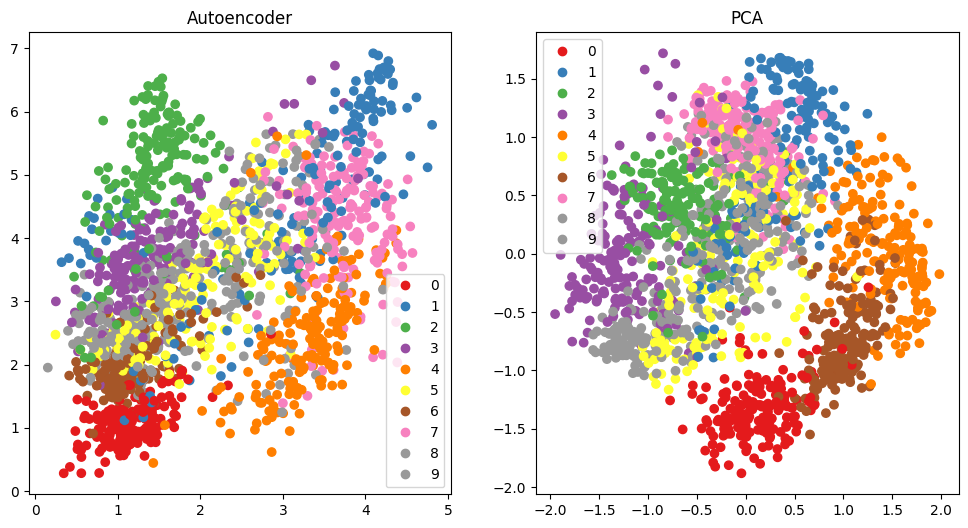

In [13]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

scatter = ax[0].scatter(x_reduced_autoencoder[:, 0], x_reduced_autoencoder[:, 1], c=y_data, cmap="Set1")
ax[0].legend(handles=scatter.legend_elements()[0], labels=list(digits['target_names']))
ax[0].set_title("Autoencoder")

scatter = ax[1].scatter(x_reduced_pca[:, 0], x_reduced_pca[:, 1], c=y_data, cmap="Set1")
ax[1].legend(handles=scatter.legend_elements()[0], labels=list(digits['target_names']))
ax[1].set_title("PCA")
plt.show()

**Questions 1**:
* Describe how these two dimensionality reductions are qualitatively different.
* Why are they different? Isn't an autoencoder supposed to be similar to PCA? What conditions (for autoencoder to emulate PCA) have been violated?
* Which of these two would you be more comfortable as using as inputs to a classification model?

Answer here

### Question 2: Linearity

The linearity of PCA means we can reconstruct any image simply as the weighted sum of the PCA vectors. For instance, here, the original example is:

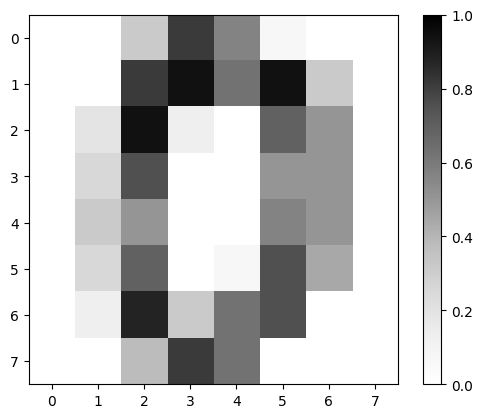

In [14]:
EXAMPLE_NUMBER = 0
plt.imshow(x_data[0].reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
plt.colorbar()
plt.show()

The PCA reduction can also be interpreted as "vector weights", here the reduction is:

In [15]:
x_reduced_pca[EXAMPLE_NUMBER]

array([-0.07871665, -1.32968022])

The "basis vectors" obtained by the PCA are the following. As you saw in the assignment, you can interpret them as "hybrid" images:

(2, 64)


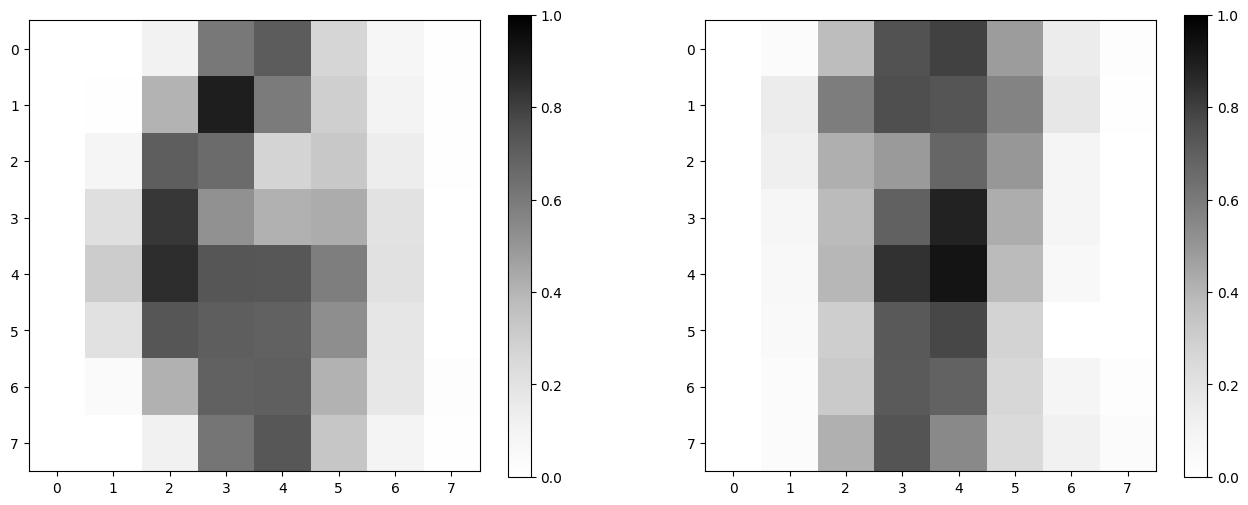

In [16]:
print(pca.components_.shape)

fig, ax = plt.subplots(figsize=(16, 6), ncols=2)

img0 = ax[0].imshow((pca.components_[0] + pca.mean_).reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
fig.colorbar(img0, ax=ax[0])
img1 = ax[1].imshow((pca.components_[1] + pca.mean_).reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
fig.colorbar(img0, ax=ax[1])
plt.show()


We can then produce a weighted sum to get back the "PCA reconstruction" of our image, as:

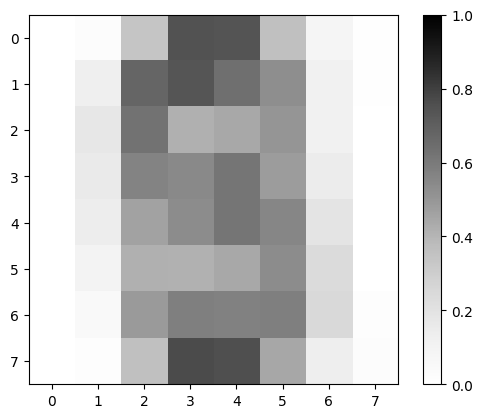

In [17]:
reconstruction = x_reduced_pca[EXAMPLE_NUMBER][0] * pca.components_[0] + x_reduced_pca[EXAMPLE_NUMBER][0] * pca.components_[1]
reconstruction = reconstruction + pca.mean_
plt.imshow(reconstruction.reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
plt.colorbar()
plt.show()

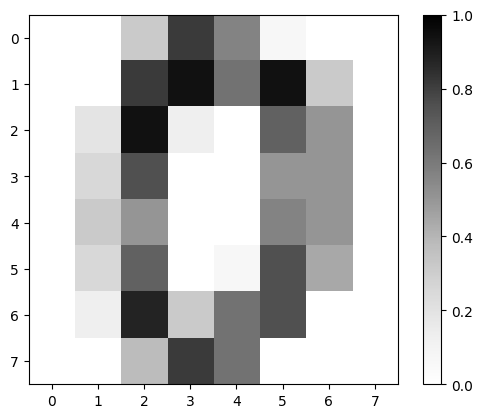

**Questions 2**:
* How does the PCA reconstruction compare to the one you did for pre-class? Is it clearer or blurrier?
* Why are we adding the PCA mean when visualizing these vectors?  (Hint: we're *undoing* something)
* PCA allows us to linearly add components to get reconstructions of the original data (given the compressed version). Do autoencoders allow us to do so?
    * If so, what are the "component vectors" of an autoencoder (the weights are the output of the bottleneck layer)?
    * If not, why not?

Answer here.